In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [23]:
from collections import defaultdict

In [2]:
import utils.metrics as utils_metrics

In [3]:
import hashlib

In [4]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [7]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [8]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [9]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [10]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 87.6792%
WER: 13.2758%
Mean overlap: 3.833


In [11]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [12]:
aggregate_rover_with_clf_

<function __main__.aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None, preaggregated=None)>

In [13]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              0,
                                              cluster_refernces, 
                                              print_)

In [14]:
import matplotlib.pyplot as plt

In [15]:
import pickle

In [16]:
with open('../notebooks/pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated = pickle.load(f)
len(preaggregated)

3486

In [17]:
import seaborn as sns
sns.set(style="whitegrid")

In [24]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = min(score for value, score in item1)
#             scores = sorted([(value, score) for value, score in item1], key=lambda x: x[1])
#             score = scores[-1][1]
            tokens = [value for value, score_ in item1 if value != ""]
            tokens = []
            prev_question = False
            for value, score_ in item1:
                if score_ > threshold_by_word and value != "" and value != "?":
                    tokens.append(value)
                    prev_question = False
                elif not prev_question and value != "":
                    tokens.append("?")
                    changed_signs_in_aggregated += 1
                    prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    # print("Number of changed \'?\': {}".format(changed_signs_in_aggregated))
    return results

In [25]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.6846747656650313)],
 2: [('', 0.8797422806822525)],
 3: [('', 0.935914017338639)],
 4: [('', 0.9476157703498646)],
 5: [('', 0.9642552025849801)],
 6: [('', 0.9860052903329602)],
 7: [('', 0.9829542698996759)],
 8: [('', 0.9819593114274828)],
 9: [('', 0.9882454214427111)],
 10: [('', 0.9902087289873817)]}

In [26]:
res_with_words = aggregate_rover_with_clf_by_word(valid_rows, 
                                 {},
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                 None, 
                                 threshold_by_word=0.8210526315789474,
                                 treshhold=0.948,
                                 min_cost=3,
                                 max_cost=7,
                                 preaggregated=preaggregated)

In [27]:
pd.DataFrame(list(res_with_words.values())).sample(20)

,text,confidence,cost
140,,0.972821,3
163,с гуглом больше не трахайся,0.984128,3
50,энергоэффект плюс сыктывкар,0.954767,4
2424,,0.967463,3
65,где мои бубенчики,0.985191,3
1000,самый последний новый фильм,0.989418,3
2556,,0.965320,3
1304,потому что,0.979307,3
1116,алиска ты где привет я пришла из сада,0.991414,3
1034,титаник тоже классный,0.965577,5


In [28]:
conf_0 = 0
for key, value in res_with_words.items():
    if value.confidence == 0:
        conf_0 += 1
conf_0 / len(res_with_words)

0.0

In [29]:
from functools import partial

In [30]:
from collections import defaultdict

In [31]:
threshhold = 0.948
evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_, 
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))

Recall: 85.6099%
WER: 6.8220%
Mean overlap: 4.001


(0.8560986032503954, 0.06822048315753658, 4.0014343086632245)

In [36]:
scores_clf_score_by_word_q_mean_v3 = defaultdict(list)

for threshhold in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.97, 0.98]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.5, 0.9, 21):
        if threshhold == 1 and th_by_word == 1:
            continue
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))
    
        if metrics[0] < baseline_loaded_new_metrics[1]:
            break
        if metrics[0] >= baseline_loaded_new_metrics[1] and metrics[1] < baseline_loaded_new_metrics[2]:
            scores_clf_score_by_word_q_mean_v3[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v3[threshhold] = np.array(scores_clf_score_by_word_q_mean_v3[threshhold])


0.7
0.5
Recall: 93.4414%
WER: 11.4187%
Mean overlap: 3.466
0.52
Recall: 93.3065%
WER: 11.3935%
Mean overlap: 3.466
0.54
Recall: 93.1612%
WER: 11.3199%
Mean overlap: 3.466
0.56
Recall: 93.1056%
WER: 11.2921%
Mean overlap: 3.466
0.58
Recall: 92.9021%
WER: 11.2298%
Mean overlap: 3.466
0.6
Recall: 92.8012%
WER: 11.2184%
Mean overlap: 3.466
0.62
Recall: 92.6881%
WER: 11.1020%
Mean overlap: 3.466
0.64
Recall: 92.5745%
WER: 11.0507%
Mean overlap: 3.466
0.66
Recall: 92.4529%
WER: 11.0158%
Mean overlap: 3.466
0.6799999999999999
Recall: 92.3340%
WER: 10.9801%
Mean overlap: 3.466
0.7
Recall: 92.2312%
WER: 10.9292%
Mean overlap: 3.466
0.72
Recall: 91.4770%
WER: 10.7655%
Mean overlap: 3.466
0.74
Recall: 90.7477%
WER: 10.6189%
Mean overlap: 3.466
0.76
Recall: 89.8520%
WER: 10.4266%
Mean overlap: 3.466
0.78
Recall: 88.6341%
WER: 10.0847%
Mean overlap: 3.466
0.8
Recall: 87.3013%
WER: 9.7829%
Mean overlap: 3.466
0.8200000000000001
Recall: 85.7251%
WER: 9.3943%
Mean overlap: 3.466
0.8400000000000001
Re

In [37]:
with open('../notebooks/pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

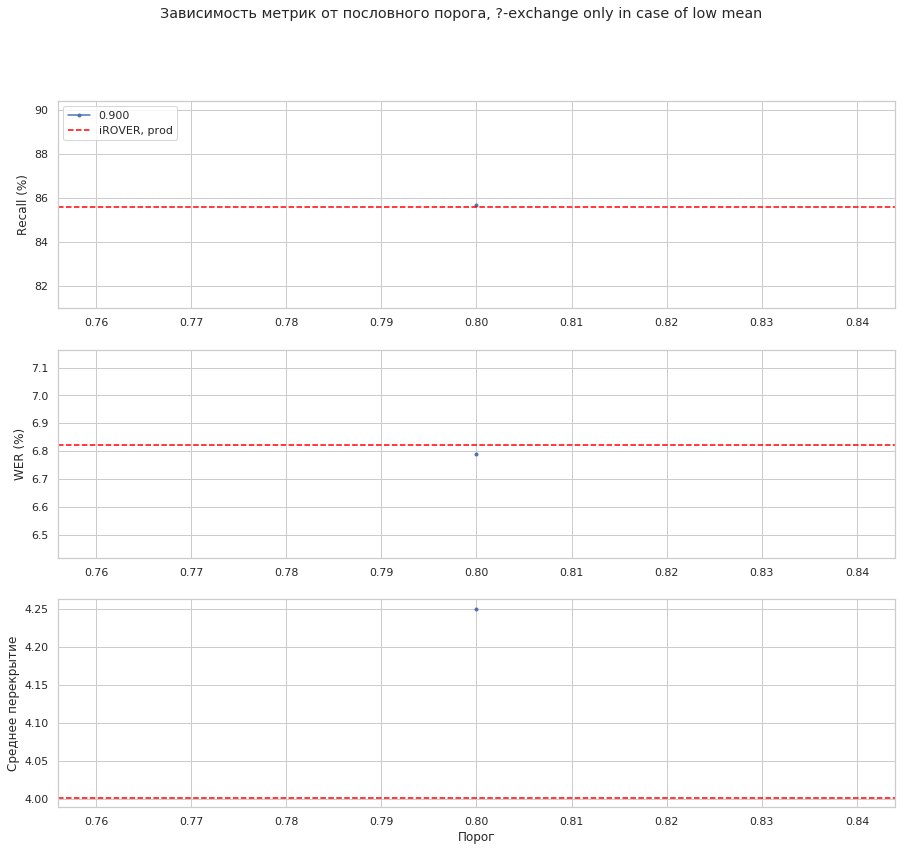

In [38]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label='{:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    if len(value):
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.show()

In [214]:
scores_clf_score_by_word_q_mean_v3[0.948][15]

array([0.975     , 0.86586285, 0.06766235, 4.00143431])

In [215]:
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [39]:
prod_agg_metrics

(0.8767924734303595, 0.1327584734909929, 3.8330464716006887)